<a href="https://colab.research.google.com/github/kavyajeetbora/modern_geospatial_stack/blob/master/notebooks/02_download_metro_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 915.4 kB/s eta 0:00:00


In [115]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
from tqdm import tqdm

## Download OSM Data

In [64]:
## Note: the coordinates are in West, South, East, North format

bboxs = {
    'Mumbai': (72.7712628039,18.8895552464,73.0912396106,19.322318006),
    'Hyderabad': (78.2288393192,17.1952635128,78.692325037,17.6244114807),
    'Bangalore': (77.4480254838,12.815481916,77.7549560258,13.1026335949),
    'Chennai': (80.0337033915,12.8678089117,80.335827415,13.2370438819),
    'Kolkata': (88.2431406976,22.4883995072,88.4944529534,22.7071046611),
    'Ahmedabad': (72.4617185823,22.9179551449,72.699297928,23.1470216925),
    'Dehli_NCR': (76.881197,28.31444,77.604922,28.893765)
}

Length of the dataframe 2999
CPU times: user 1.25 s, sys: 89.4 ms, total: 1.34 s
Wall time: 1.4 s


<Axes: >

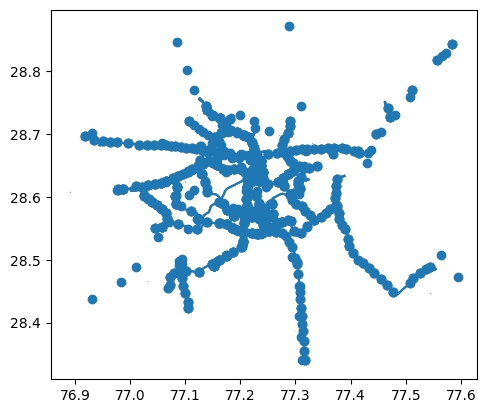

In [103]:
%%time
city = 'Dehli_NCR'

for city, bbox in bboxs.items():

    ## Download OSM data
    W,S,E,N = bboxs[city]
    public_transport = ox.features.features_from_bbox(bbox=(N,S,E,W), tags={'subway':True, 'public_transport': 'station', 'railway':'subway'}).reset_index()
    print("Length of the dataframe" , public_transport.shape[0])

    ## Extract Metro Stops
    metro_stops = public_transport.loc[(public_transport['element_type']=='node') & (public_transport['subway']=='yes') & (public_transport['public_transport']=='station')]
    print(f"Number of stations: {metro_stops.shape[0]}")




Number of stations: 261


<Axes: >

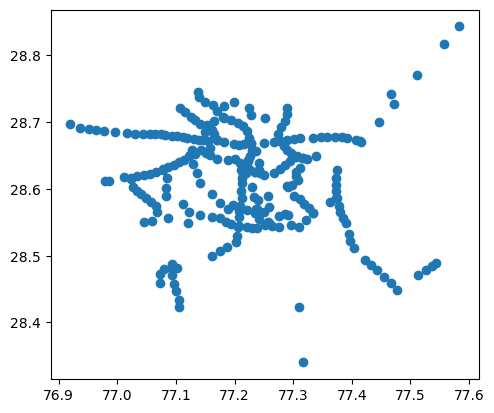

In [112]:
metro_stops = public_transport.loc[(public_transport['element_type']=='node') & (public_transport['subway']=='yes') & (public_transport['public_transport']=='station')]
print(f"Number of stations: {metro_stops.shape[0]}")
metro_stops.plot()

In [124]:
bus_stops = ox.features.features_from_bbox(bbox=(N,S,E,W), tags={'public_transport': 'station'}).reset_index()
bus_stops[bus_stops['subway']!='yes'].to_csv('bus_stops.csv')

Number of lines: 477


<Axes: >

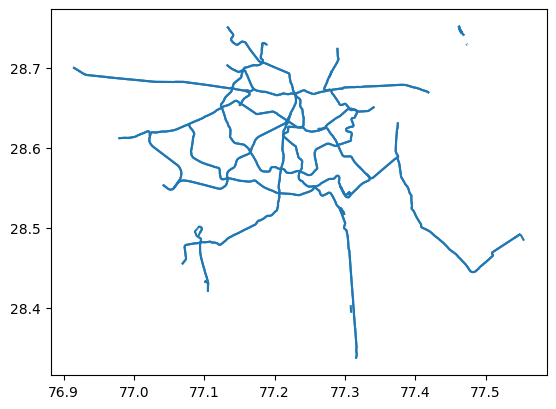

In [113]:
metro_lines = public_transport.loc[(public_transport['railway']=='subway') & (public_transport['name'].notna())]
print(f"Number of lines: {metro_lines.shape[0]}")
metro_lines.plot()

In [ ]:
metro_lines.to_parquet(f'{}_metro_lines.parquet')
metro_stops.to_parquet(f'{}_metro_stops.parquet')